In [3]:
import scattering
import healpy as hp
import numpy as np
import pymaster as nmt
import matplotlib.pyplot as pl

In [19]:
nside = 2048


ldir = '/Users/shivam/Library/CloudStorage/Dropbox/research/yuuki_data/'
ksz_noiseless_yuuki = hp.read_map(ldir + 'yuuki/ksz/mdpl2_lkszNG_bahamas76_rot_sum_4_176_bnd_unb_1.0e+12_1.0e+18_v103021_lmax24000_nside8192_interp1.6_method1_1_lensed_map.fits')
ksz_noiseless_yuuki = hp.ud_grade(ksz_noiseless_yuuki, nside)



In [34]:
# ldir = '/Users/shivam/Dropbox/research/yuuki_data/'
M_lim = 1e13
z_lim = 0.5

all_ind = np.arange(0,52)
# all_ind
zall, vall, mall, ra_all, dec_all = [], [], [], [], []
from tqdm import tqdm
for ji in tqdm(range(len(all_ind))):
    df = np.load(ldir + 'yuuki/halolc/haloslc_rot_' + str(ji+1) + '.npy')
    m200c = df[:,3]
    indsel = np.where(m200c > M_lim)[0]
    zsel = df[:,2][indsel]
    vsel = df[:,7][indsel]
    rasel = df[:,0][indsel]
    decsel = df[:,1][indsel]   
    msel = m200c[indsel]
    indsel = np.where(zsel < z_lim)[0]
    zsel = zsel[indsel]
    vsel = vsel[indsel]
    rasel = rasel[indsel]
    decsel = decsel[indsel]
    msel = msel[indsel]
    zall.append(zsel)
    vall.append(vsel)
    ra_all.append(rasel)
    dec_all.append(decsel)
    mall.append(msel)
    





100%|██████████| 52/52 [00:00<00:00, 70.24it/s] 


In [40]:
datapoint_ra, datapoint_dec = np.hstack((ra_all)), np.hstack((dec_all))
datapoint_w = np.ones_like(datapoint_ra)
print(len(datapoint_ra))
nestpix = hp.ang2pix(nside,datapoint_ra, datapoint_dec,nest=True,lonlat=True)
pix = nestpix
pix.sort()
first = np.where(pix[:-1] != pix[1:])[0] + 1
first = np.concatenate(([0],first))
hpix = pix[first]
cts = np.diff(first,append=len(pix))
m = np.zeros(hp.nside2npix(nside),dtype=int)
m[hpix] = cts
density_halo = -1 + m/np.mean(m)
density_halo = hp.reorder(density_halo, n2r=True)



3300821


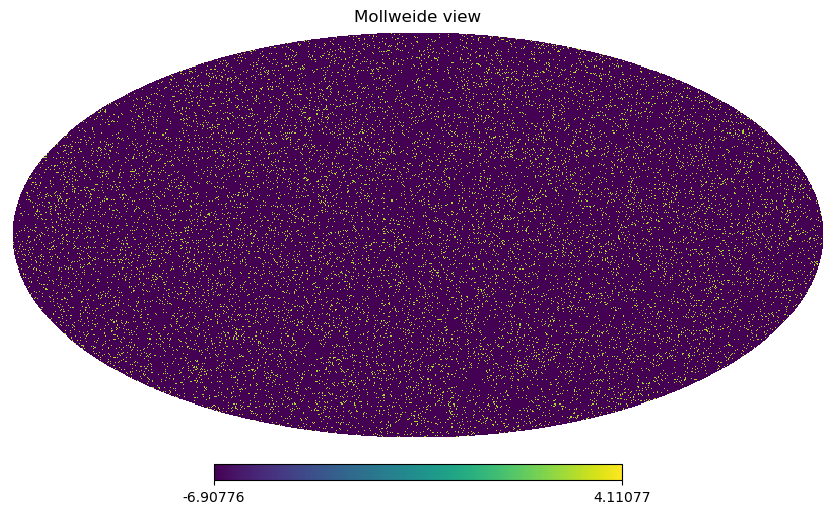

In [36]:
hp.mollview(np.log(np.abs(1.001 + density_halo)))


In [38]:
njk = 625
# njk = 150
all_cens = np.loadtxt('./center_ra_dec_njk' + str(njk) + '.txt').T



In [39]:
area_per_jk = 41253/njk
print(np.sqrt(area_per_jk))
area_per_pixel = hp.nside2pixarea(nside, degrees=True)
n_per_jk = area_per_jk/area_per_pixel
xsize_f = int(np.sqrt(n_per_jk))
print(xsize_f)




8.12433381884324
283


In [68]:
from tqdm import tqdm
# saveinit = True
saveinit = False
sdir_Cls = './temp_Cls'
size_deg = hp.nside2resol(hp.npix2nside(len(ksz_noiseless_yuuki)), arcmin=True) * xsize_f / 60.
if saveinit:
    all_cens_range = [0]
else:
    all_cens_range = np.arange(len(all_cens))

Cls_abs01_all = []
Cls_001_all = []

map_ksz_all = []
map_halo_all = []

for jc in tqdm(all_cens_range):
    raj, decj = all_cens[jc][0], all_cens[jc][1]
    mt1 = hp.gnomview(
        ksz_noiseless_yuuki,
        rot=(raj, decj),
        xsize=xsize_f,
        no_plot=True,
        reso=hp.nside2resol(hp.npix2nside(len(ksz_noiseless_yuuki)), arcmin=True),
        return_projected_map=True
        )
    
    mt2 = hp.gnomview(
        density_halo,
        rot=(raj, decj),
        xsize=xsize_f,
        no_plot=True,
        reso=hp.nside2resol(hp.npix2nside(len(density_halo)), arcmin=True),
        return_projected_map=True
        )    
    
    Lx = size_deg * np.pi / 180.
    Nx = mt1.shape[0]
    Ly = Lx

    maskf = np.ones_like(mt1)
    fabs0 = nmt.NmtFieldFlat(Lx, Ly, maskf, [np.abs(mt1)])
    f00 = nmt.NmtFieldFlat(Lx, Ly, maskf, [(mt1**2)])
    f1 = nmt.NmtFieldFlat(Lx, Ly, maskf, [mt2])    

    wabs0_1 = nmt.NmtWorkspaceFlat()
    w00_1 = nmt.NmtWorkspaceFlat()    

    nbins_ell = 8
    l0_bins = np.arange(nbins_ell) * (Nx // nbins_ell) * np.pi / Lx
    lf_bins = (np.arange(nbins_ell) + 1) * (Nx // nbins_ell) * np.pi / Lx
    bf = nmt.NmtBinFlat(l0_bins, lf_bins)
    ells_uncoupled = bf.get_effective_ells()

    if saveinit:
        # print(jc, jM, jsnv)
        # if jc == 0 and jM == 0 and jsnv == 0:
        np.save(sdir_Cls + '/ells_kappa', ells_uncoupled)
        # w00 = nmt.NmtWorkspaceFlat()
        wabs0_1 = nmt.NmtWorkspaceFlat()
        w00_1 = nmt.NmtWorkspaceFlat()    

        wabs0_1.compute_coupling_matrix(fabs0, f1, bf)
        w00_1.compute_coupling_matrix(f00, f1, bf)

        wabs0_1.write_to(sdir_Cls + '/wabs0_1_flat.fits')
        w00_1.write_to(sdir_Cls + '/w00_1_flat.fits')        
        # return 0
    else:
        wabs0_1.read_from(sdir_Cls + '/wabs0_1_flat.fits')
        w00_1.read_from(sdir_Cls + '/w00_1_flat.fits')        

        clabs0_1_coupled = nmt.compute_coupled_cell_flat(fabs0, f1, bf)
        clabs0_1_uncoupled = wabs0_1.decouple_cell(clabs0_1_coupled)

        cl00_1_coupled = nmt.compute_coupled_cell_flat(f00, f1, bf)
        cl00_1_uncoupled = w00_1.decouple_cell(cl00_1_coupled)        

        if len(Cls_abs01_all) == 0:
            Cls_abs01_all = clabs0_1_uncoupled
            Cls_001_all = cl00_1_uncoupled
        else:
            Cls_abs01_all = np.vstack((Cls_abs01_all, clabs0_1_uncoupled))
            Cls_001_all = np.vstack((Cls_001_all, cl00_1_uncoupled))

        if len(map_ksz_all) == 0:
            map_ksz_all = mt1.reshape(xsize_f, xsize_f, 1)
            map_halo_all = mt2.reshape(xsize_f, xsize_f, 1)
        else:
            map_ksz_all = np.dstack((map_ksz_all, mt1.reshape(xsize_f, xsize_f, 1)))
            map_halo_all = np.dstack((map_halo_all, mt2.reshape(xsize_f, xsize_f, 1)))




100%|██████████| 625/625 [02:17<00:00,  4.54it/s]


In [90]:
# l0_bins
# Nx
# len(np.arange(Nx / 40))
# np.arange(Nx / 8) * 8 * np.pi / Lx
Nx//8


35

In [65]:
# np.arange(Nx / 40) * 40 * np.pi / Lx


array([   0.        ,  888.66703797, 1777.33407594, 2666.0011139 ,
       3554.66815187, 4443.33518984, 5332.00222781, 6220.66926578])

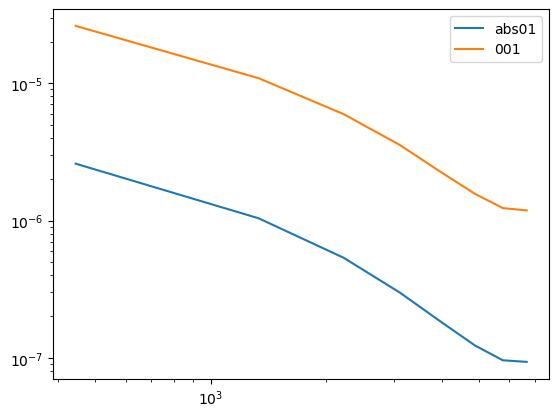

In [70]:
import matplotlib.pyplot as pl
pl.figure()
pl.plot(ells_uncoupled, np.mean(Cls_abs01_all, axis=0), label='abs01')
pl.plot(ells_uncoupled, np.mean(Cls_001_all, axis=0), label='001')
pl.xscale('log')
pl.yscale('log')
pl.legend()


In [71]:
cov_abs_01 = np.cov(Cls_abs01_all.T)
cov_001 = np.cov(Cls_001_all.T)
sig_abs_01 = np.sqrt(np.diag(cov_abs_01))
sig_001 = np.sqrt(np.diag(cov_001))


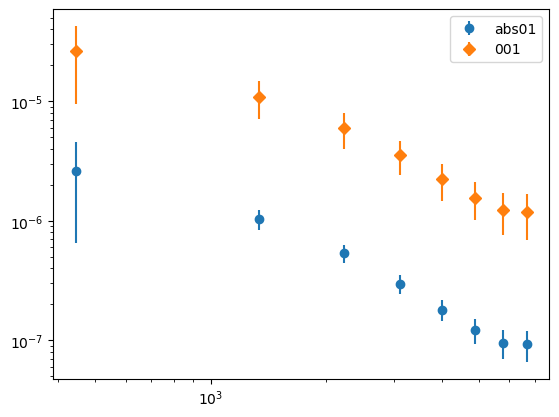

In [72]:
import matplotlib.pyplot as pl
pl.figure()
pl.errorbar(ells_uncoupled, np.mean(Cls_abs01_all, axis=0), yerr=sig_abs_01, ls='', marker='o', label='abs01')
pl.errorbar(ells_uncoupled, np.mean(Cls_001_all, axis=0), yerr=sig_001, ls='', marker='D', label='001')
pl.xscale('log')
pl.yscale('log')
pl.legend()


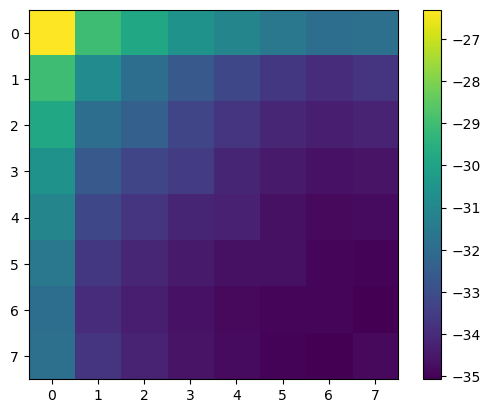

In [74]:
pl.figure()
pl.imshow(np.log(np.abs(cov_abs_01)))
pl.colorbar()


In [75]:
inv_cov_abs_01 = np.linalg.inv(cov_abs_01)
inv_cov_001 = np.linalg.inv(cov_001)

snr_abs_01 = np.dot(np.mean(Cls_abs01_all, axis=0), np.dot(inv_cov_abs_01, np.mean(Cls_abs01_all, axis=0)))
snr_001 = np.dot(np.mean(Cls_001_all, axis=0), np.dot(inv_cov_001, np.mean(Cls_001_all, axis=0)))

print(snr_abs_01, snr_001)


53.43249812757527 13.091340868449809


In [91]:
mt1.shape

(283, 283)

In [109]:
import sys
# sys.path.append('/Users/shivam/Library/CloudStorage/Dropbox/research/SZST/scattering')
import scattering.ST as ST
# import ST
J = 2
L = 2
M = mt1.shape[0]
N = mt1.shape[1]
# filter_set = ST.FiltersSet(M, N, J, L).generate_wavelets(precision='single')


In [111]:
ST_calculator = ST.Scattering2d(M, N, J, L, device='cpu')



In [129]:
map_ksz_all.T.shape

(625, 283, 283)

In [117]:
import torch
I1_ksz_all = ST_calculator.get_I1(torch.Tensor(map_ksz_all.T), J, L)
I1_absksz_all = ST_calculator.get_I1(torch.Tensor(map_ksz_all.T), J, L)


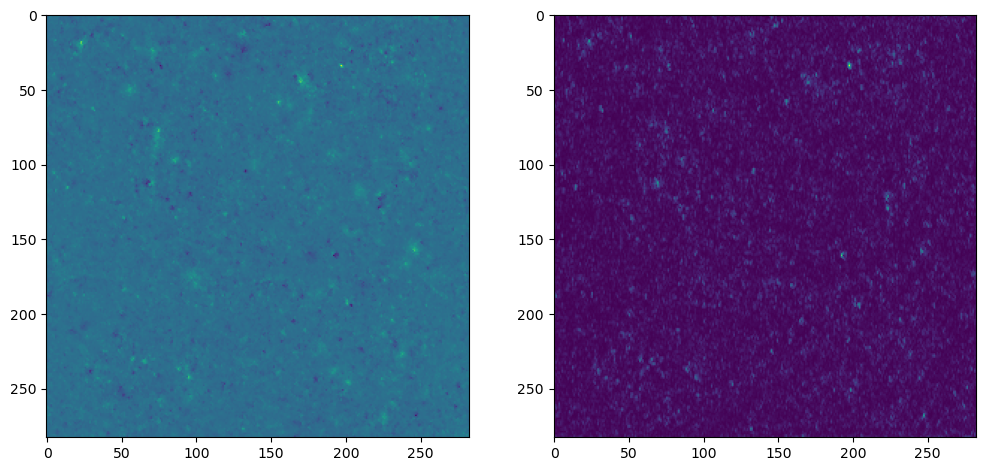

In [127]:
# plot mt1 and I1 side by side
import matplotlib.pyplot as pl
pl.figure(figsize=(12, 6))
pl.subplot(121)
pl.imshow(mt1)
# pl.colorbar()
pl.subplot(122)
pl.imshow(I1[0, 0,0, :, :].abs().numpy())
# pl.colorbar()



In [97]:
input_images = np.empty((30, M, N), dtype=np.float32)

S, S0, S1, S2, _, _, _, _ = ST_calculator.forward(input_images, J, L)



{'psi': tensor([[[[ 0.0000e+00,  4.0356e-03,  8.1664e-03,  ..., -1.1518e-02,
            -7.7785e-03, -3.9385e-03],
           [ 4.0356e-03,  8.1656e-03,  1.2392e-02,  ..., -7.7600e-03,
            -3.9288e-03,  3.5662e-06],
           [ 8.1664e-03,  1.2392e-02,  1.6715e-02,  ..., -3.9092e-03,
             1.4280e-05,  4.0400e-03],
           ...,
           [-1.1518e-02, -7.7600e-03, -3.9092e-03,  ..., -2.2224e-02,
            -1.8752e-02, -1.5183e-02],
           [-7.7785e-03, -3.9288e-03,  1.4280e-05,  ..., -1.8752e-02,
            -1.5192e-02, -1.1533e-02],
           [-3.9385e-03,  3.5662e-06,  4.0400e-03,  ..., -1.5183e-02,
            -1.1533e-02, -7.7847e-03]],
 
          [[ 0.0000e+00, -5.5511e-17,  8.3267e-17,  ..., -8.3267e-17,
            -5.5511e-17,  0.0000e+00],
           [ 5.3704e-03,  5.3696e-03,  5.3670e-03,  ...,  5.3628e-03,
             5.3670e-03,  5.3696e-03],
           [ 1.0953e-02,  1.0951e-02,  1.0946e-02,  ...,  1.0937e-02,
             1.0946e-02,  1.0951

In [89]:

# pl.figure(figsize=(6, 6))
# pl.imshow(mt2.reshape(xsize_f, xsize_f, 1))

